# Rare Cell Coverage (cell type)

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import pickle

# Get the file path from environment variable
file_path_env = '/fast/AG_Ohler/ekarimi/projects/FACS_Sampling/data'
OBS_FEATURES = ['celltype']

REFERENCES = [5, 10, 20, 25, 30]
METHODS = ['random', 'cubic', 'hopper', 'atomic']
methods = ['random', 'cubic', 'hopper']
SIZES = [50000, 100000, 200000, 300000]
REPS = [i for i in range(5)]
label_key = 'celltype'


directory = "mcc/benchmark"
PATH = os.path.join(file_path_env, directory)

In [2]:
ref = 1
method = 'cubic'
size = 50000
rep = 0
# REFERENCES = [1, 5]
methods = ['random', 'cubic', 'atomic', 'hopper']


### saving adata.obs instead of the whole adata.
### (Not valid)

In [3]:
reference_adatas = {}
# reference_obs = {}
for ref in REFERENCES:
    address = os.path.join(PATH, f"{ref}/adata.h5ad")
    adata = sc.read_h5ad(address)
    adata.obs[label_key] = adata.obs[label_key].astype('category')
    adata.var.index = adata.var.index.astype('object')
    reference_adatas[ref] = adata
    # reference_obs[ref] = adata.obs

In [4]:
res = {}
new_label_orders = {}

for ref in REFERENCES:
    adata = reference_adatas[ref]

    real_counts = adata.obs[label_key].value_counts()
    rare_dict = real_counts < adata.shape[0]/100
    rare_types = [x for x in rare_dict.keys() if rare_dict[x]==True]
    adata.obs['rare'] = adata.obs.apply(lambda x: True if x[label_key] in rare_types else False , axis=1)
    adata.obs['real_count'] = adata.obs.apply(lambda x: real_counts[x[label_key]] , axis=1)

    label_order = adata.obs[label_key].value_counts().keys().values
    
    group_dict = {
        label_key:[],
        'count':[],
        'method':[],
        'ref_size':[],
        'sample_size':[],
        'rep':[],
        # 'rare':[],
        'real_count':[],
                 }

    for size in SIZES:
        for method in METHODS:
            for rep in REPS:
                if method == 'atomic':
                    if os.path.isfile(os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")):
                        atomic_address = os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")
                        indices = pd.read_csv(atomic_address)['x'].values.astype(str)
                    else:
                        continue
                else:
                    samples_address = os.path.join(PATH, f"{ref}/{method}/{size}/{rep}/results.pkl")
                    with open(samples_address, 'rb') as handle:
                         samples= pickle.load(handle)
                    indices = samples[0]

                counts = adata[indices].obs[label_key].value_counts().tolist()
                labels = adata[indices].obs[label_key].value_counts().keys().tolist()
                # value_counts = adata[indices].obs[label_key].value_counts()
                # counts = value_counts.tolist()
                # labels = value_counts.keys().tolist()

                method_rep = [method for _ in counts]
                size_rep = [size for _ in counts]
                ref_rep = [ref for _ in counts]
                rep_rep = [rep for _ in counts]
                real_count = real_counts[labels].values
                # rare = rare_dict[labels].values

                group_dict[label_key].extend(labels)
                group_dict['count'].extend(counts)
                group_dict['method'].extend(method_rep)
                group_dict['ref_size'].extend(ref_rep)
                group_dict['sample_size'].extend(size_rep)
                group_dict['rep'].extend(rep_rep)
                # group_dict['rare'].extend(rare)
                group_dict['real_count'].extend(real_count)
                
                
                

    gdf = pd.DataFrame.from_dict(group_dict)
    # cc = adata.obs[label_key].value_counts()
    # gdf['coverage_percent'] = gdf.apply(lambda x: (x['count'] / cc[x[label_key]]) * 100, axis=1)
    
    res[ref] = gdf[gdf[label_key].isin(rare_types)]
    
    new_label_order = []
    for i in range(len(label_order)):
        if label_order[i] in rare_types:
            new_label_order.append(label_order[i])
    new_label_orders[ref] = new_label_order

In [6]:
output = {}
for ref in REFERENCES:
    df = res[ref]
    output[ref] = None
    b= []
    for size in SIZES:
        a = []
        for method in METHODS:
            sample_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['count'].sum()
            sample_count /= len(REPS)
            # real_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['real_count'].sum()
            # real_count /= len(REPS)
            # a.append(sample_count/real_count)
            a.append(sample_count)
        b.append(a)
    b = np.array(b).T
    output[ref] = b

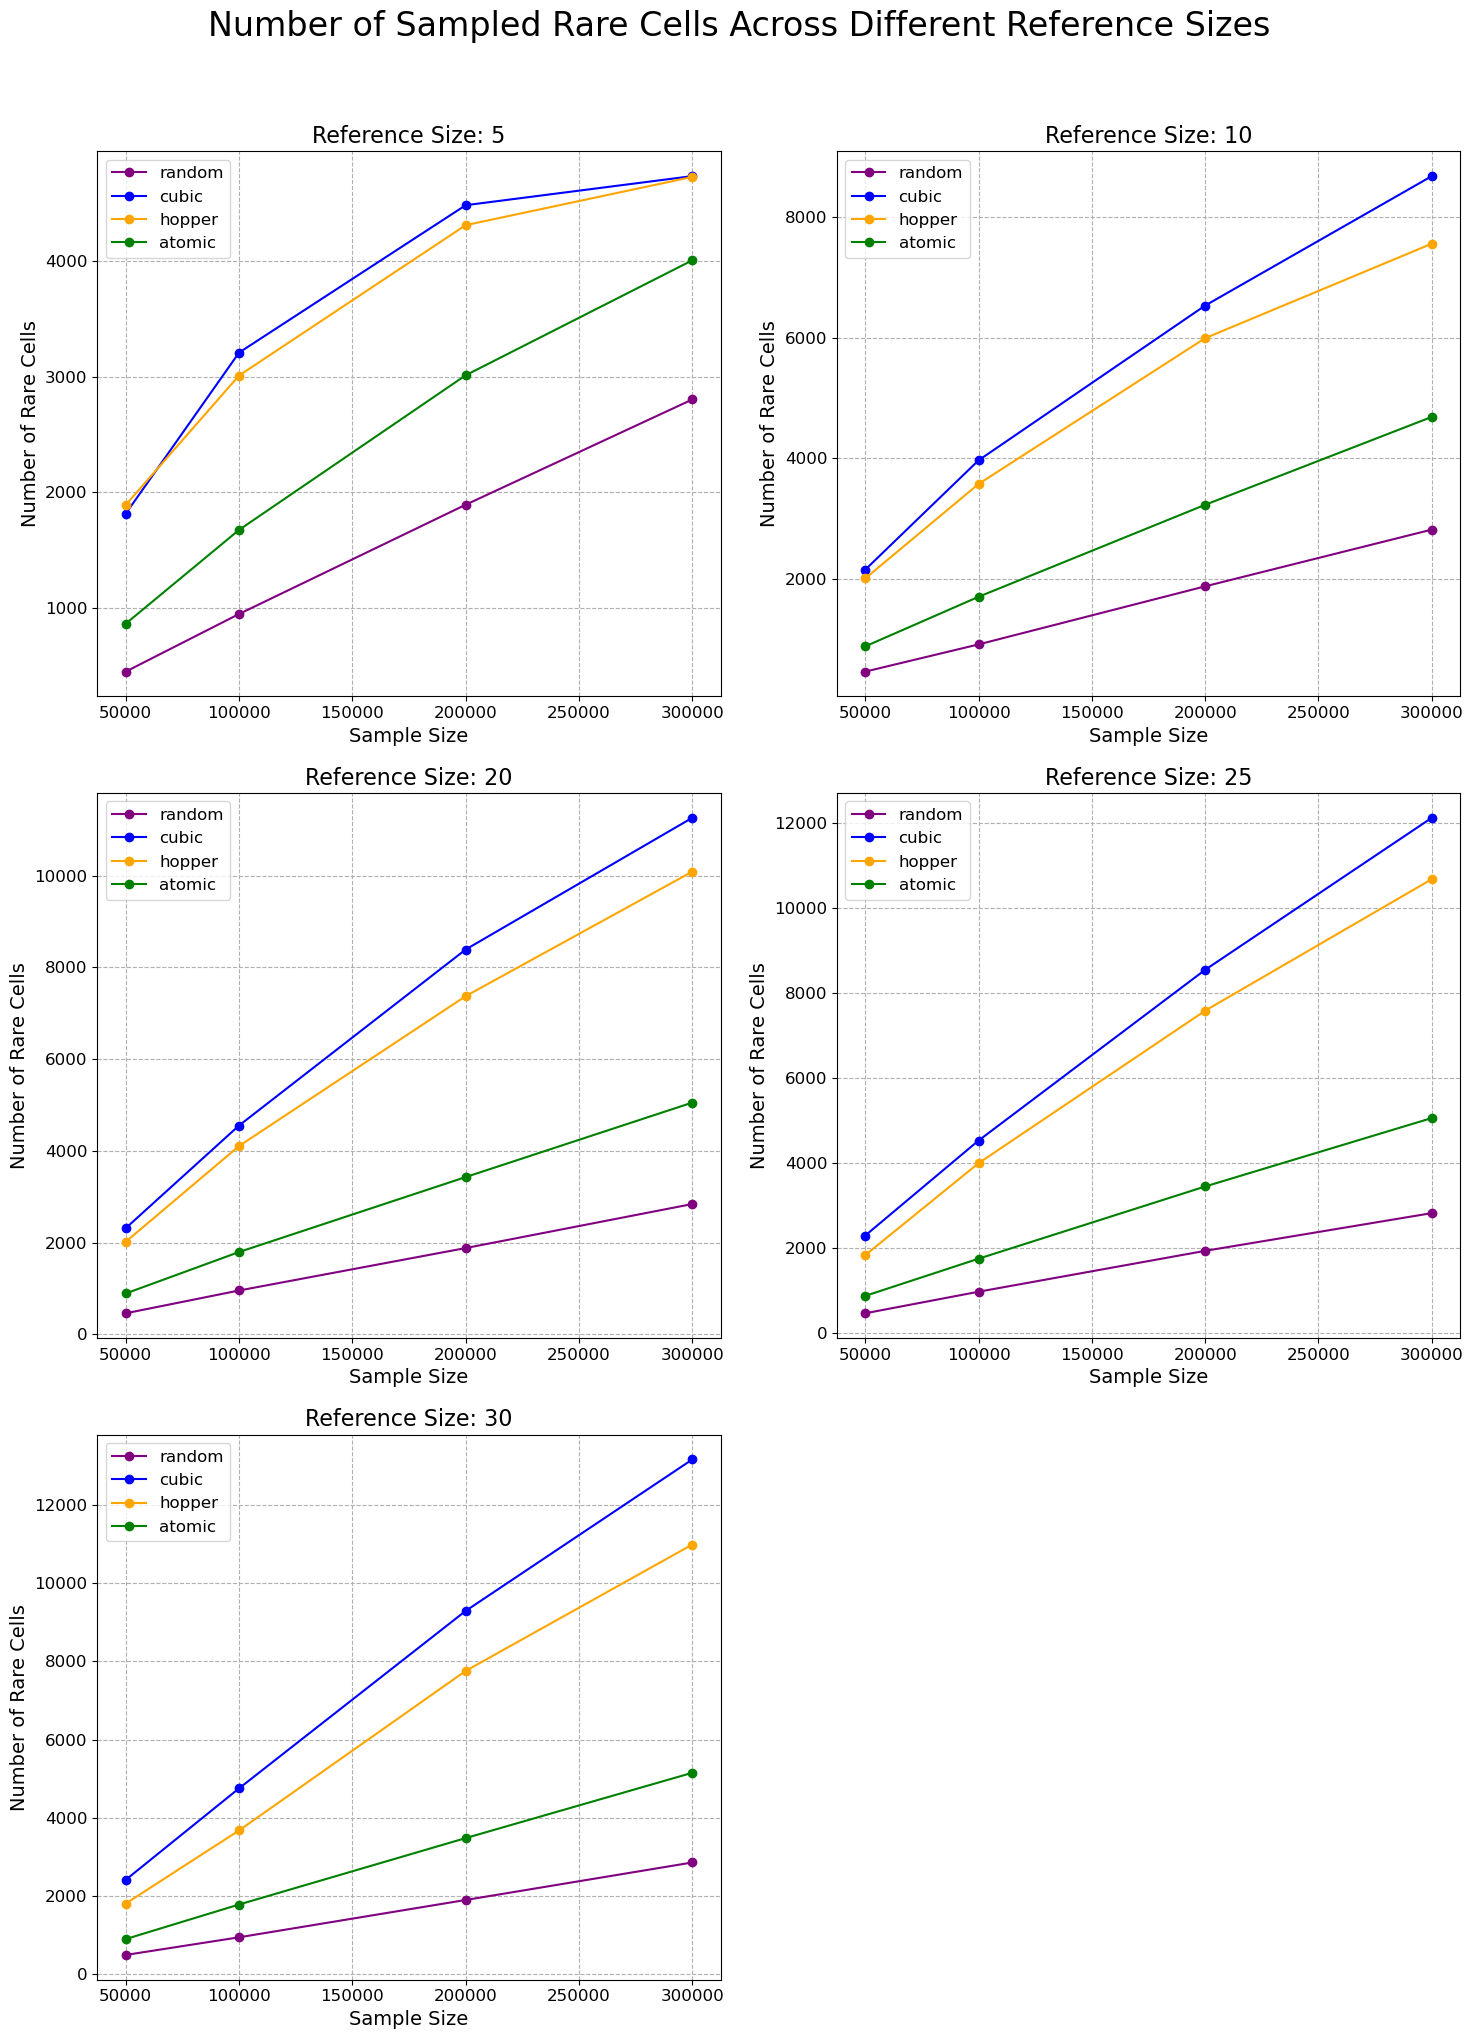

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Assuming 'a' is your dataset container with 7 datasets, and 'methods_list' is defined
# a = {...}
# methods_list = [...]

# Fixed X-axis values
x_values = np.array(SIZES)

# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 3  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
colors = ['purple', 'blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

y_min = 0  # Replace with your desired minimum y value
y_max = 0.9  # Replace with your desired maximum y value

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, ref in enumerate(output.keys()):
    y_streams = output[ref]
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot
    for j, y_stream in enumerate(y_streams):
        ax.plot(x_values, y_stream, '-o', color=colors[j % len(colors)], label=METHODS[j])

    # Customizations for the subplot
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Number of Rare Cells')
    ax.set_title(f'Reference Size: {ref}')
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(output), n_rows * n_cols):
    fig.delaxes(axes[i])
    
    
fig.suptitle('Number of Sampled Rare Cells Across Different Reference Sizes', size=24, y=1.02)

# Adjust layout to prevent overlapping
fig.tight_layout()

# Save the entire figure with all subplots to a file
plt.savefig('rare_population_coverage_ref_fixed.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


In [8]:
output2 = {}
for size in SIZES:    
    output2[size] = None
    b= []
    for ref in REFERENCES:
        df = res[ref]
        a = []
        for method in METHODS:
            sample_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['count'].sum()
            sample_count /= len(REPS)
            # real_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['real_count'].sum()
            # real_count /= len(REPS)
            # a.append(sample_count/real_count)
            a.append(sample_count)
        b.append(a)
    b = np.array(b).T
    output2[size] = b

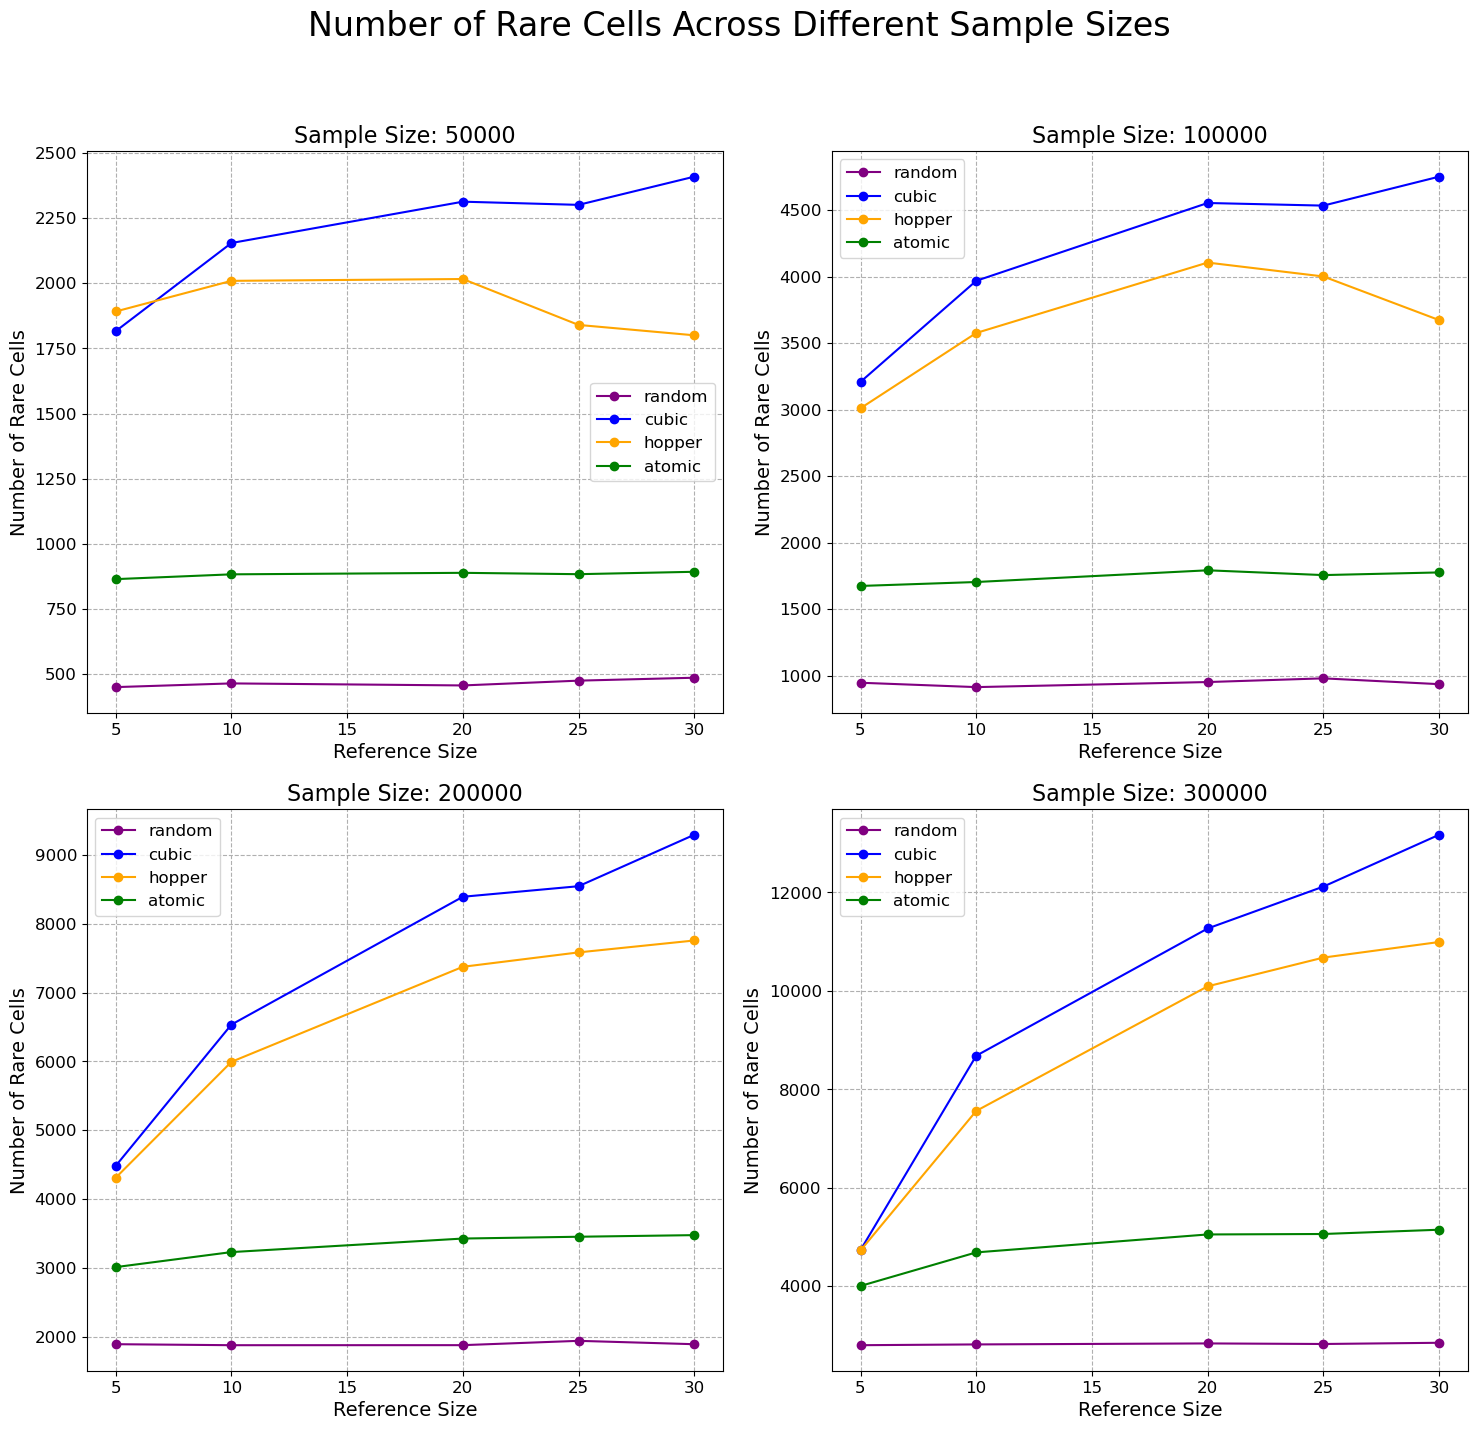

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Assuming 'a' is your dataset container with 7 datasets, and 'methods_list' is defined
# a = {...}
# methods_list = [...]

# Fixed X-axis values
x_values = np.array(REFERENCES)

# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 3  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
colors = ['purple', 'blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

y_min = 0  # Replace with your desired minimum y value
y_max = 0.9  # Replace with your desired maximum y value

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, size in enumerate(output2.keys()):
    y_streams = output2[size]
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot
    for j, y_stream in enumerate(y_streams):
        ax.plot(x_values, y_stream, '-o', color=colors[j % len(colors)], label=METHODS[j])

    # Customizations for the subplot
    ax.set_xlabel('Reference Size')
    ax.set_ylabel('Number of Rare Cells')
    ax.set_title(f'Sample Size: {size}')
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(output2), n_rows * n_cols):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlapping
fig.suptitle('Number of Rare Cells Across Different Sample Sizes', size=24, y=1.02)

fig.tight_layout()

# plt.subplots_adjust(top=0.9)

# Save the entire figure with all subplots to a file
plt.savefig('rare_population_coverage_sample_size_fixed.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


In [10]:
adata.obs['celltype'].value_counts()

celltype
mesodermal cell            1463100
lateral mesodermal cell     745494
fibroblast                  648047
chondrocyte                 274756
osteoblast                   30000
Name: count, dtype: int64